In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import jax
from jax import grad
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)
from quad_utils import *
from other_utils import *


## Numerical methods for integration

Using the function:

$$
f(x) = e^{-x^2}\sin(5x) + \frac{\log(1+x^2)}{1+x^4} + (x^2 + \cos(3x) + 1.1)^{1/3},
$$

Monte Carlo integration approximates the expected value of a function by averaging its values at random sample points.
Specifically, $\mathbb{E}[f(X)] \approx \frac{1}{n} \sum_{i=1}^n f(x_i)$ for $x_i$ sampled from the input domain.


### MC Integration

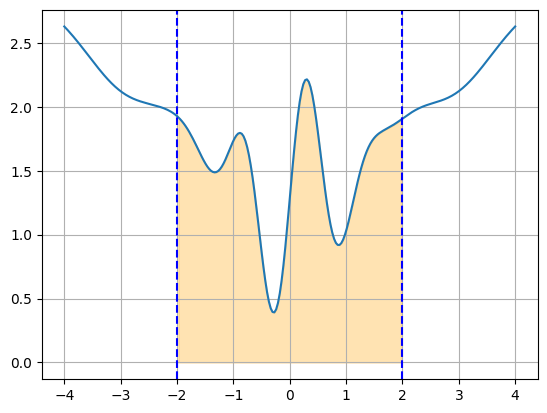

True value: 5.96051236421104

Normal Monte Carlo:
Value: 5.933243, Absolute Error: 0.027269, StDev: 0.056300

Monte Carlo with Antithetic Variables:
Value: 5.962944, Absolute Error: 0.002431, StDev: 0.035699


In [2]:
def f(x):
    return (
        jnp.exp(-x**2) * jnp.sin(5*x)
        + jnp.log(1 + x**2) / (1 + x**4)
        + (x**2 + jnp.cos(3*x) + 1.1)**(1/3)
    )

# Define integration bounds
lower = -2
upper = 2
interval = upper - lower

# Generate a dense set of points for plotting the function
points = np.linspace(lower-0.5*interval, upper+0.5*interval, 250)
y = f(points)

# Mask points that lie within the integration bounds for shading
mask = (points >= lower) & (points <= upper)
points_fill = points[mask]
y_fill = y[mask]

# Plotting
plt.plot(points, y)
plt.axvline(lower, color='b', linestyle='--')
plt.axvline(upper, color='b', linestyle='--')
plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3)
plt.grid()
plt.show()


# known exact integral for comparison
true_value = 5.96051236421104  

# MC Integration
n = 1000
x = np.random.uniform(0,1,n)
x1 = lower + x*interval
mc = jnp.mean(f(x1)) * interval
error1 = np.abs(true_value - mc)
StDev1 = np.sqrt(np.var(f(x1))/n)*interval

# MC Integration using Antithetic Variables
n = 500
x = 1 - x
x2 = lower + x*interval
x1 = x1[:n]
x2 = x2[:n]
mc_at = (0.5*np.mean(f(x1)) + 0.5*np.mean(f(x2)))*interval
error2 = np.abs(true_value - mc_at)
StDev2 = np.sqrt(np.var(0.5*f(x1) + 0.5*f(x2))/n)*interval

# Print results for comparison
print(f"True value: {true_value}\n")
print("Normal Monte Carlo:")
print(f"Value: {mc:.6f}, Absolute Error: {error1:.6f}, StDev: {StDev1:.6f}\n")
print("Monte Carlo with Antithetic Variables:")
print(f"Value: {mc_at:.6f}, Absolute Error: {error2:.6f}, StDev: {StDev2:.6f}")


$1000$ function evaluations needed for MC gives StDev of approximately $0.055$, or $0.035$ when using antithetic variates


$$
\boxed{v[k] = \left( \sigma_f^2 \cdot \sigma \sqrt{2\pi} \right) \, \left[\frac{1}{2} \text{erf} \left(\frac{x-s}{\sigma\sqrt{2}} \right) - \frac{1}{2} \text{erf}\left(\frac{a-s}{\sigma\sqrt{2}} \right) \right]}
$$     

$$
\boxed{vv[k] = \sigma_f^2 \left[ \sigma \sqrt{2\pi} \, (x-a) \, \text{erf} \left( \frac{x-a}{\sigma \sqrt{2}} \right) + 2 \sigma^2 \left( e^{-{\frac{(x-a)^2}{2 \sigma^2}}} - 1 \right) \right]}
$$


$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$


where 

$$
\textbf{k}_F(x) = \Big[ \int_a^x k(t, x_1)dt,\, \int_a^x k(t, x_2)dt,\, \cdots ,\, \int_a^x k(t, x_n)dt \Big],
$$

$$
K(x'x) = \int_a^x \int_a^{x'} k(t, s)\,ds\,dt 
$$

and $K = k(X,X)$ is the Gram matrix of the training inputs under the kernel k.

##### Using the same function, integrating now using bayesian quadrature

Bayesian Quadrature
2 pts:
True value: 5.96051236421104

Estimate: 2.40366535 , StDev: 3.86153254
Absolute Error: 3.55684701



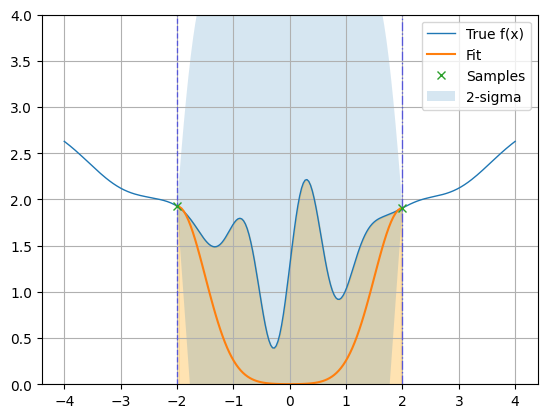

4 pts:
True value: 5.96051236421104

Estimate: 5.50091991 , StDev: 1.76728514
Absolute Error: 0.45959246



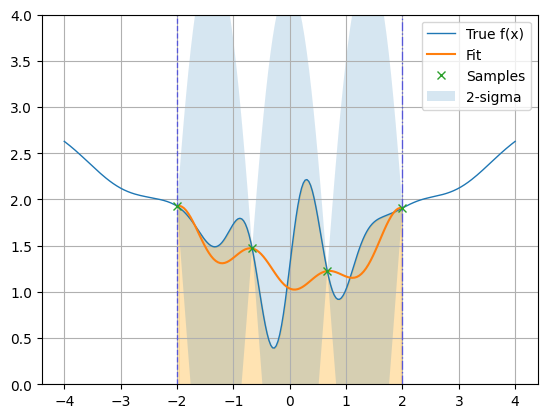

6 pts:
True value: 5.96051236421104

Estimate: 6.06668822 , StDev: 0.36595099
Absolute Error: 0.10617586



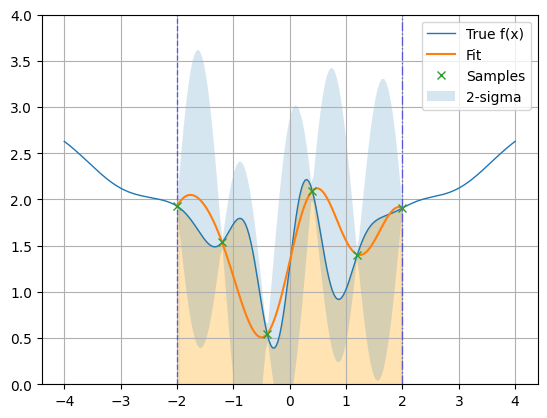

10 pts:
True value: 5.96051236421104

Estimate: 5.98532396 , StDev: 0.04149714
Absolute Error: 0.02481159



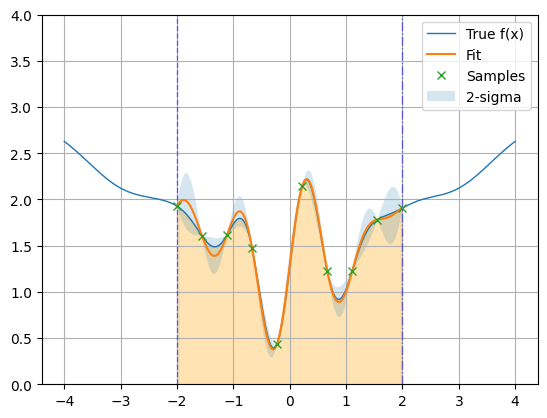

15 pts:
True value: 5.96051236421104

Estimate: 5.96336359 , StDev: 0.00280257
Absolute Error: 0.00285122



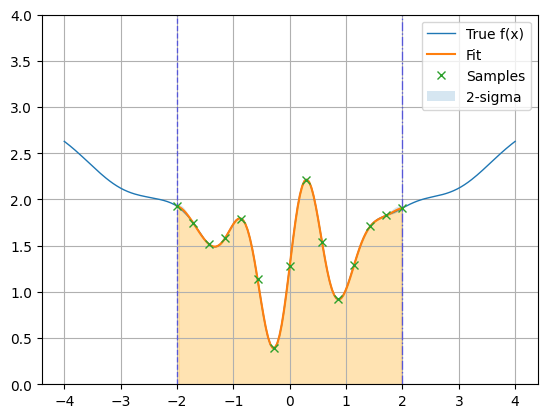

In [8]:
# Define integration bounds
lower = -2
upper = 2
interval = upper - lower


points = np.linspace(lower-0.5*interval, upper+0.5*interval, 250)
yy = f(points)

mask = (points >= lower) & (points <= upper)
points_fill = points[mask]
y_fill = yy[mask]


# Known true value of the integral for comparison
true_value = 5.96051236421104

# Evaluation points for plotting the Gaussian Process fit
x_eval = np.linspace(lower, upper, 100)
print("Bayesian Quadrature")

# Loop over different numbers of sample points
for n in [2,4,6,10,15]:
    # Select n evenly spaced sample points within the integration bounds
    x = jnp.linspace(lower, upper, n)
    y = f(x)

    # Plotting 
    plt.plot(points, yy, label='True f(x)', linewidth=1)
    plt.axvline(lower, color='b', linestyle='--', linewidth=1, alpha=0.5)
    plt.axvline(upper, color='b', linestyle='-.', linewidth=1, alpha=0.5)
    plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3)
    plt.grid()

    s = 2
    L = jnp.array([0.5])
    # Compute GP posterior mean and variance at evaluation points
    mu_eval, var_eval = gp_predict_1(x, y, x_eval, kernel=rbf, s=s, L=L)
    sig_diag = jnp.sqrt(jnp.diag(var_eval))

    # Compute Bayesian Quadrature estimate of the integral and its variance formulated above
    I_mu, I_var = integrate_rbf(x, y, lower, upper, s, L)
    error = np.abs(true_value - I_mu[0][0])
    
    # Print results
    print(f"{n} pts:")
    print(f"True value: {true_value}\n")
    print(f"Estimate: {I_mu[0][0]:.8f} , StDev: {np.sqrt(I_var[0][0]):.8f}")
    print(f"Absolute Error: {error:.8f}\n")

    # Plotting
    plt.plot(x_eval, mu_eval, label='Fit')
    plt.plot(x, y, 'x', label='Samples')
    plt.ylim(0, 4)
    plt.fill_between(x_eval, mu_eval-2*sig_diag, mu_eval+2*sig_diag, alpha=0.18, label='2-sigma')
    plt.legend()
    plt.show()


Much fewer function evaluations (around 6-15) are needed to get an accurate estimate

## Univariate Single Gaussian
### Integrating $f(t)p(t)$

Results derived in Appendix A of report
$$
\boxed{\mathbb{E}_{f|\mathbf{D}}[F(x)] = M(x) + \mathbf{k}_F^T(x) K^{-1} \Big(f(X)-m(X) \Big)}
$$

$$
\boxed{\text{Cov}_{f|\mathbf{D}}\left(F(x), F(x')\right) = K(x,x') - \mathbf{k}_F^T(x) K^{-1} \mathbf{k}_F(x')}
$$

$$
\boxed{v[k] = \sigma_f^2 \sqrt{\frac{l^2}{l^2 + \sigma_p^2}} \; \exp\left[- \frac{(s - \mu_p)^2}{2 (l^2 + \sigma_p^2)} \right]}
$$

$$
\boxed{vv[k] = \sigma_f^2 \sqrt{\frac{l^2}{l^2 + 2 \sigma_p^2}}}
$$



where $$\textbf{k}_F(x) = \Big[ \int k(t, x_1)p(t)dt,\, \int k(t, x_2)p(t)dt,\, \cdots ,\, \int k(t, x_n)p(t)dt \Big]$$,
$$K(x'x) = \int \int k(t, s)p(t)p(s)\,ds\,dt $$

and $K = k(X,X)$ is the Gram matrix of the training inputs under the kernel k.

Now Integrating function: 

$$
f(x) = \frac{1}{2}\Bigl(0.1 e^x - 0.5 x^2 + 1\Bigr)
$$ 

with respect to a single gaussian:
$$
p(x) = \mathcal{N}(x \mid 0.5, 0.5^2)
$$

Eₚ[f(x)]: 1.8682459574322223

Bayesian Quadrature
2 pts:
Estimate: -1.31548683 , StDev: 1.51922981
Absolute Error: 3.18373278



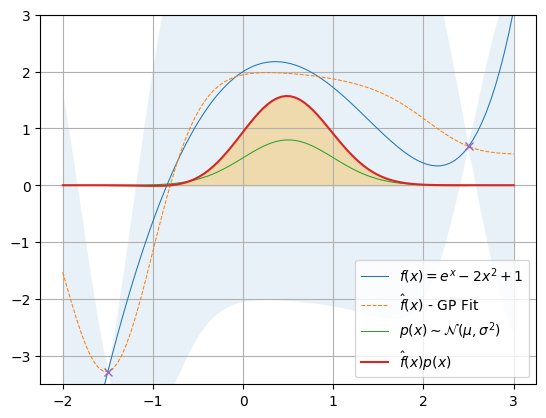

3 pts:
Estimate: 1.42810264 , StDev: 0.55507471
Absolute Error: 0.44014332



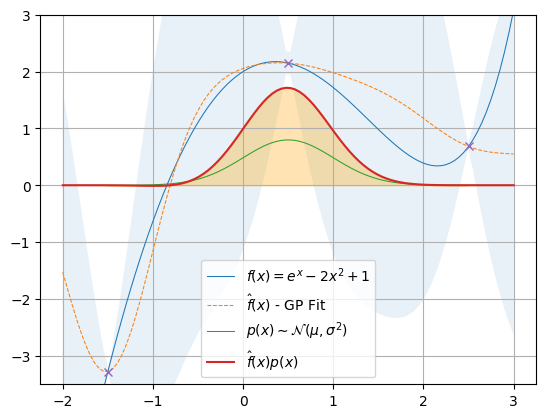

4 pts:
Estimate: 1.48308135 , StDev: 0.84298328
Absolute Error: 0.38516460



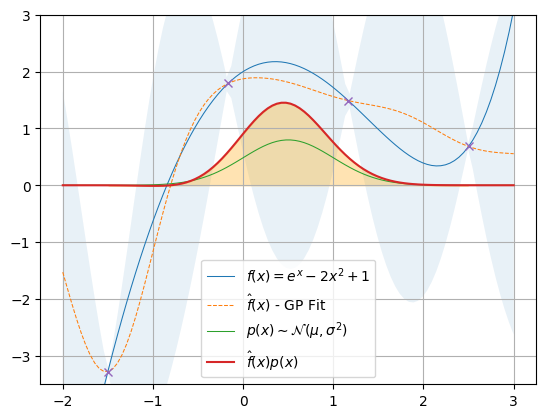

6 pts:
Estimate: 1.86276130 , StDev: 0.16444834
Absolute Error: 0.00548466



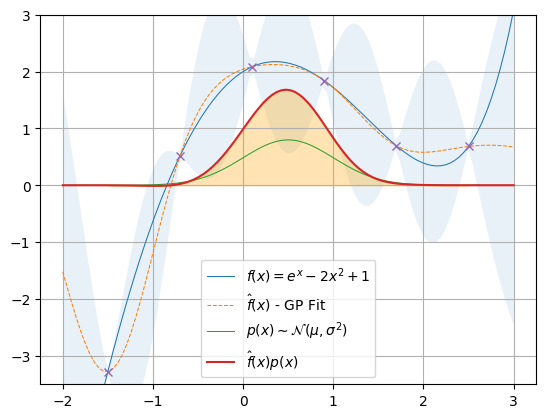

12 pts:
Estimate: 1.86824909 , StDev: 0.00001079
Absolute Error: 0.00000313



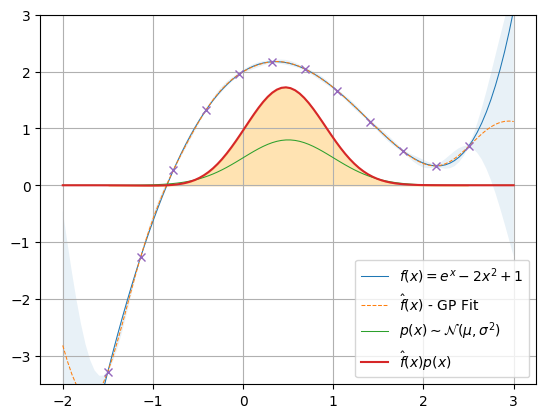

In [9]:
def f(x):
    return jnp.exp(x) - 2*x**2 + 1

def fp(x, mu, sigma):
    px = (1/(sigma*jnp.sqrt(2*jnp.pi)))*jnp.exp(-(x-mu)**2/(2*sigma**2))
    return f(x)*px

def FP(mu, sigma):
    t1 = jnp.exp(sigma**2/2 + mu)
    return t1 - 2*sigma**2 - 2*mu**2 + 1

#integral of f(x) from lower to upper
mu = 0.5
sigma = 0.5
true_value = FP(mu,sigma)

x_eval = jnp.linspace(mu-5*sigma,mu+5*sigma,100)

s = 2
L = jnp.array([0.5])
s, L, m0, x_m, w = jnp.array([s]), jnp.diag(L), jnp.array([2]),jnp.array([0]), 2
hp_sample = (s,L,m0,x_m,w,0.0)

print(f"Eₚ[f(x)]: {true_value}")
print()
print("Bayesian Quadrature")
for n in [2,3,4,6,12]:
    x = jnp.linspace(mu-4*sigma,mu+4*sigma,n)
    y = f(x)

    x,y = reshape(x,y)
    chol_k1, kxx_inv = kinv(jnp.atleast_1d(x),hp_sample)
    

    I_mu, I_var = integrate_gaussian_1(x,y,s,L,mu,sigma)

    error = np.abs(true_value - I_mu)
    print(f"{n} pts:")
    print(f"Estimate: {I_mu:.8f} , StDev: {np.sqrt(I_var):.8f}")
    print(f"Absolute Error: {error:.8f}")
    print()

    
    mu_eval, var_eval = gp_predict(
        x, y, x_eval,
        s=s,L=L,
        m0=m0,x_m=x_m,w=w, K_inv=kxx_inv)
    sig_diag = np.sqrt(jnp.clip(np.diag(var_eval[0]), 0.0))

    #real curve
    y1 = f(x_eval)
    y2 = (1/(sigma*jnp.sqrt(2*jnp.pi)))*jnp.exp(-(x_eval-mu)**2/(2*sigma**2))
    y3 = y2*mu_eval


    mask = (x_eval >= mu-4*sigma) & (x_eval <= mu+4*sigma)
    points_fill = x_eval[mask]
    y_fill = y3[mask]

    #plot gp
    plt.plot(x_eval,y1,label=r'$f(x) = e^x - 2x^2 + 1$', ls='-',lw=0.75)
    plt.plot(x_eval, mu_eval, label=r'$\hat{f}(x)$ - GP Fit', ls='--', lw=0.75)
    plt.plot(x_eval, y2, label=r'$p(x) \sim \mathcal{N}(\mu, \sigma^2)$', ls='-', lw=0.75)
    plt.plot(x_eval,y3,label=r'$\hat{f}(x)p(x)$', ls='-')
    plt.plot(x,y,'x')
    plt.fill_between(x_eval,mu_eval-2*sig_diag,mu_eval+2*sig_diag,alpha=0.1)
    plt.fill_between(points_fill, y_fill, color='orange', alpha=0.3) 
    plt.legend()
    plt.ylim(-3.5,3)
    plt.grid()
    plt.show()

## Univariate Mixture
### Integrating $f(t)p_{mix}(t)$

Using same function but with respect to a three-component Gaussian mixture:
$$
p(x) = 0.2 \, \mathcal{N}(x \mid -0.4, 0.4^2)
     + 0.3 \, \mathcal{N}(x \mid 1.5, 0.3^2)
     + 0.5 \, \mathcal{N}(x \mid 2.8, 0.5^2),
$$

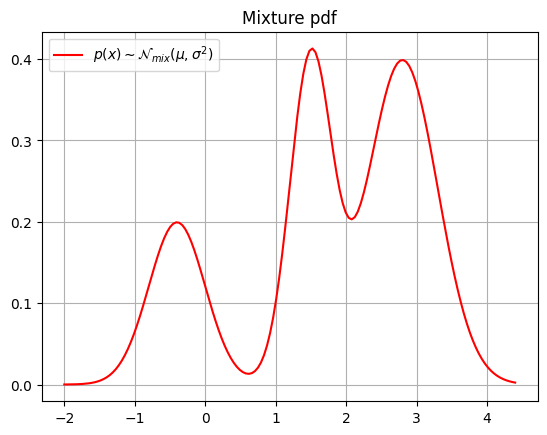

Eₚ[f(x)]: -0.15931328397645778

Bayesian Quadrature (Adaptive Selection)

1 pts:
Estimate: -0.19862177 , StDev: 0.55020901
Absolute Error: 0.03930848



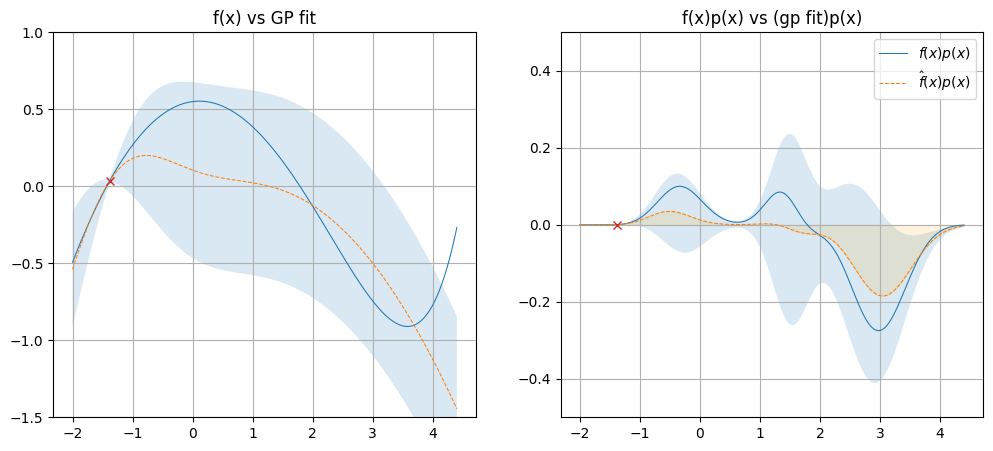

2 pts:
Estimate: -0.26446151 , StDev: 0.33130919
Absolute Error: 0.10514823



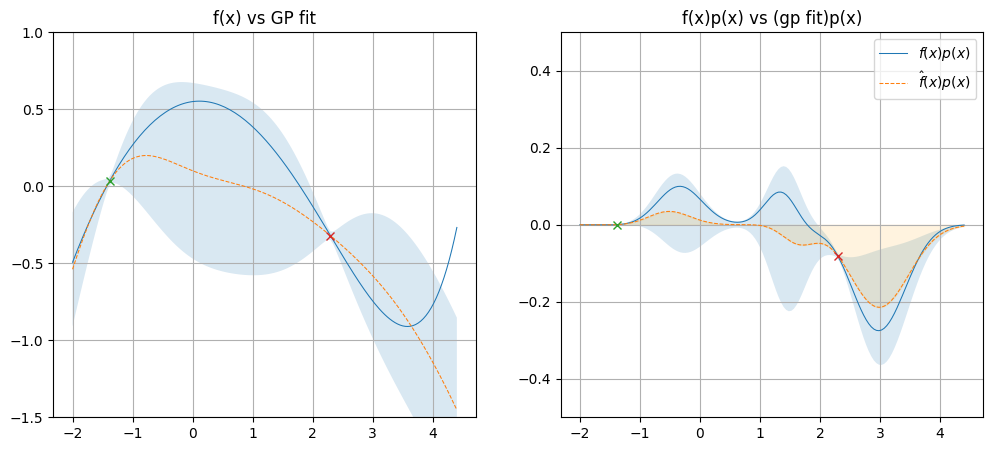

3 pts:
Estimate: -0.19377837 , StDev: 0.23719916
Absolute Error: 0.03446508



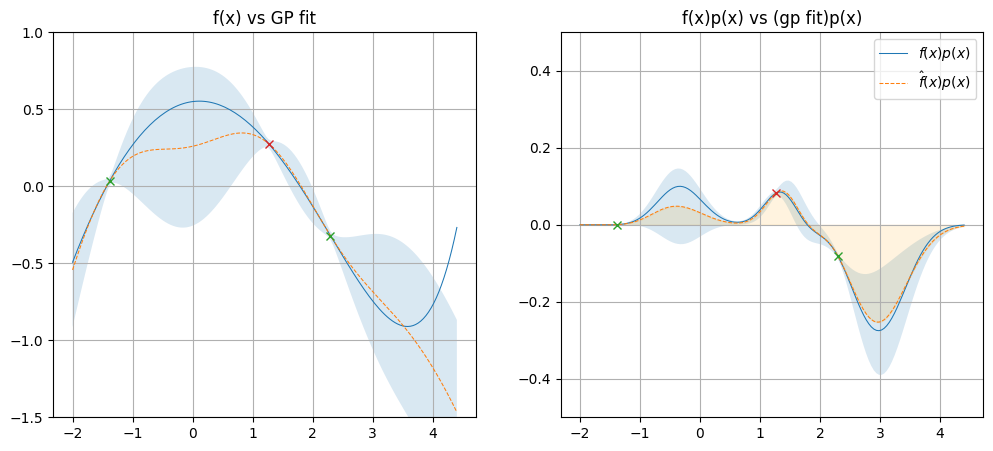

4 pts:
Estimate: -0.20772551 , StDev: 0.20309287
Absolute Error: 0.04841222



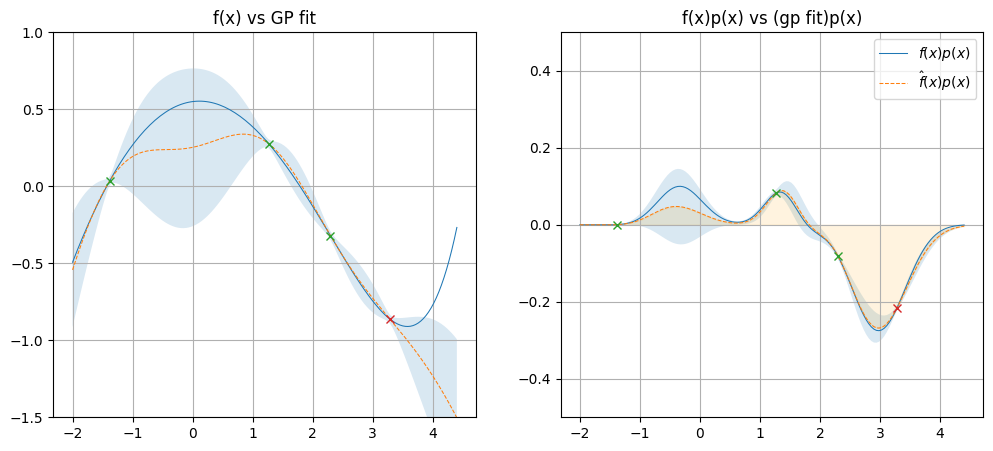

5 pts:
Estimate: -0.16528121 , StDev: 0.08513733
Absolute Error: 0.00596792



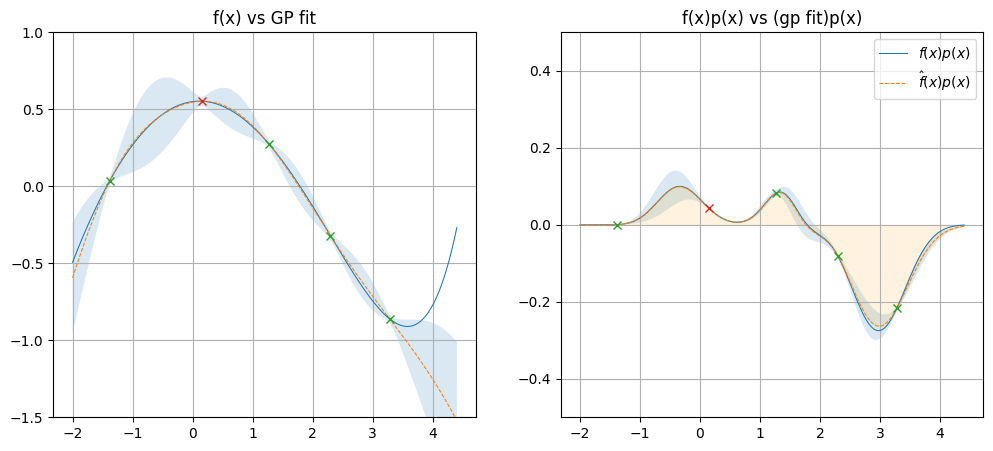

6 pts:
Estimate: -0.16071390 , StDev: 0.08442122
Absolute Error: 0.00140061



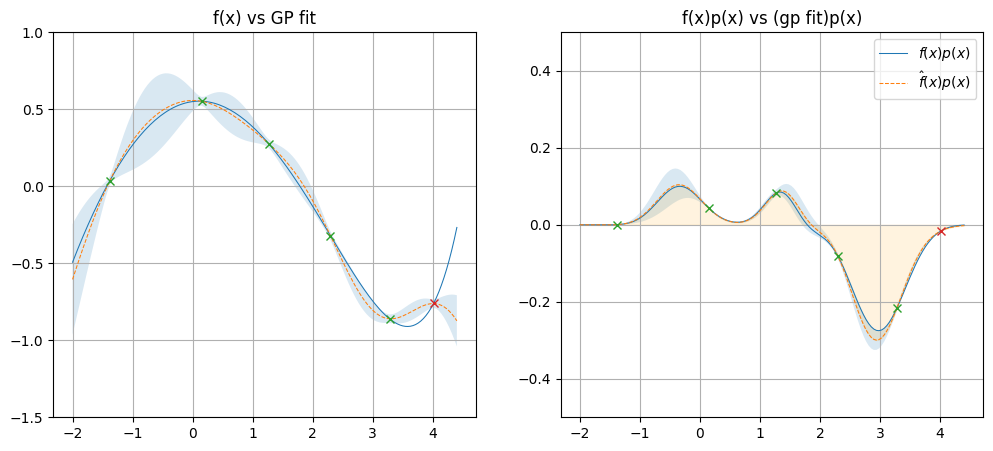

7 pts:
Estimate: -0.16464784 , StDev: 0.00963626
Absolute Error: 0.00533456



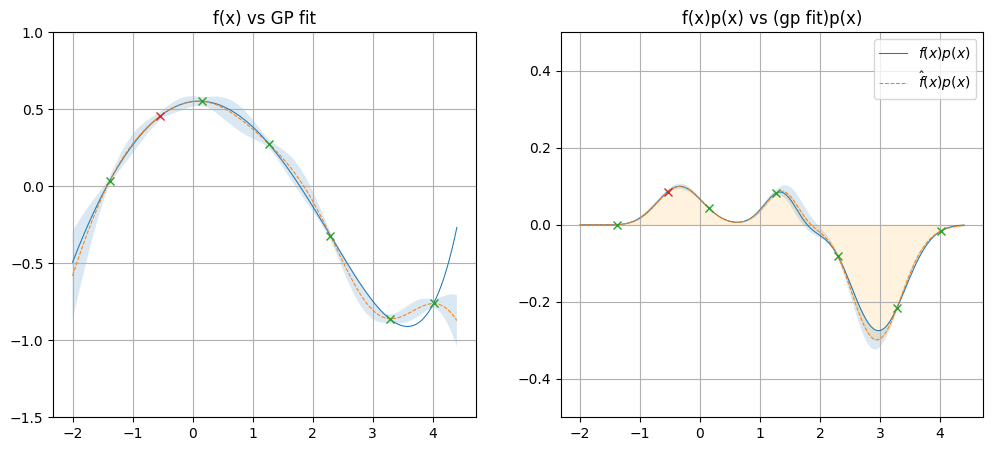

8 pts:
Estimate: -0.16517327 , StDev: 0.00578217
Absolute Error: 0.00585999



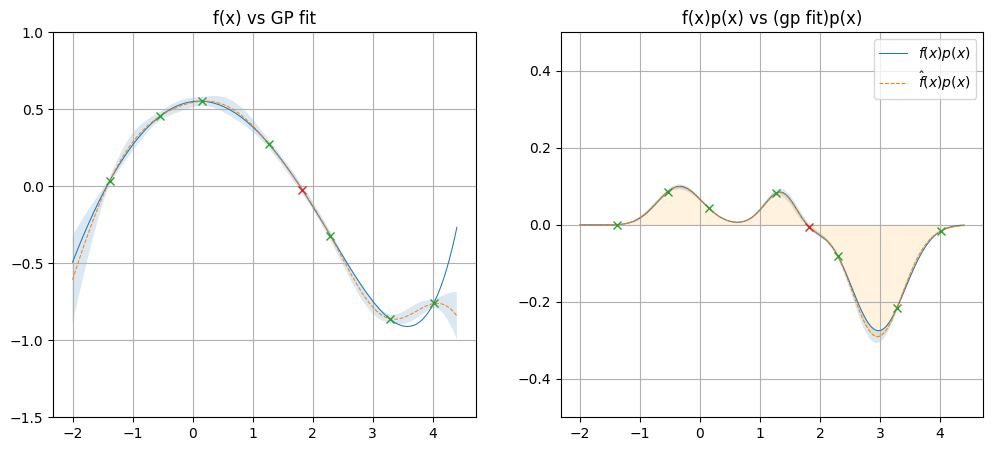

9 pts:
Estimate: -0.15864182 , StDev: 0.00157863
Absolute Error: 0.00067146



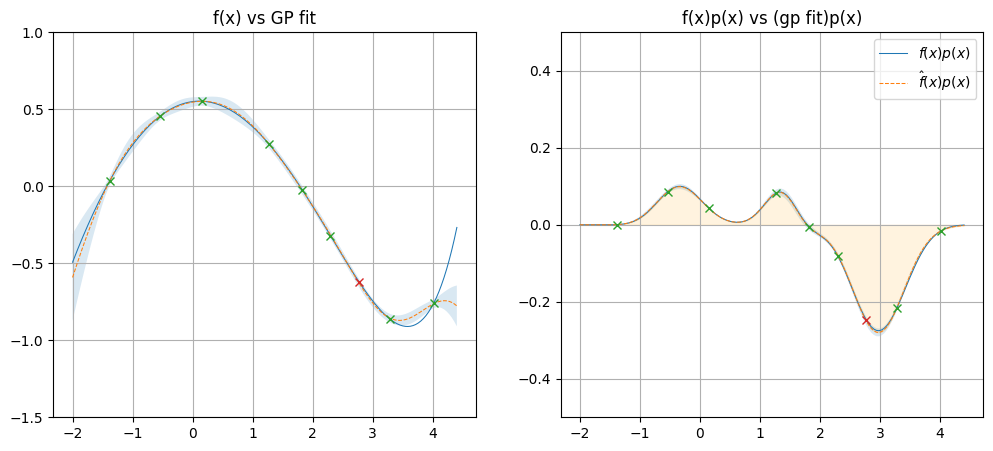

10 pts:
Estimate: -0.15858656 , StDev: 0.00152087
Absolute Error: 0.00072673



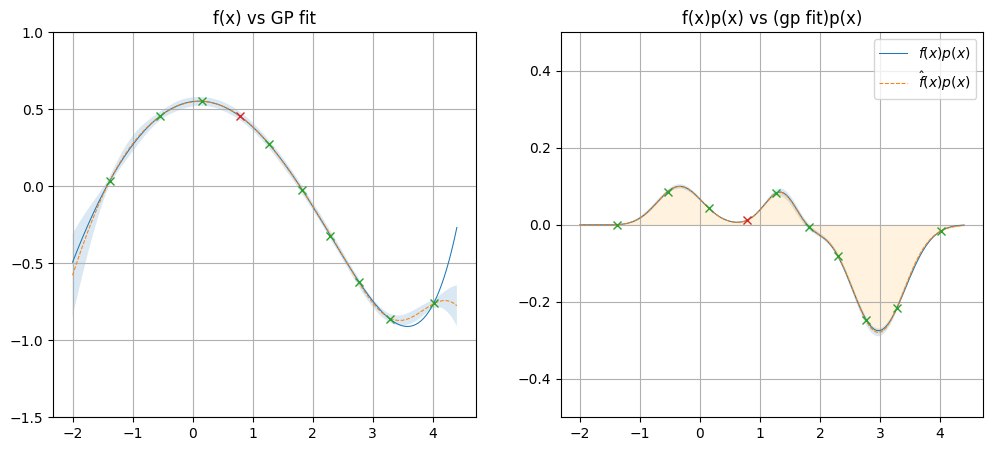

11 pts:
Estimate: -0.15994746 , StDev: 0.00145691
Absolute Error: 0.00063418



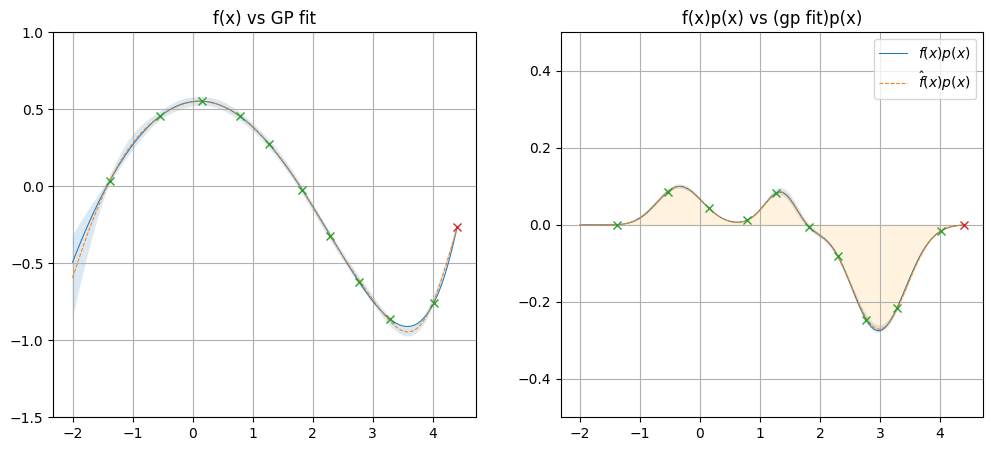

12 pts:
Estimate: -0.15920890 , StDev: 0.00128515
Absolute Error: 0.00010438



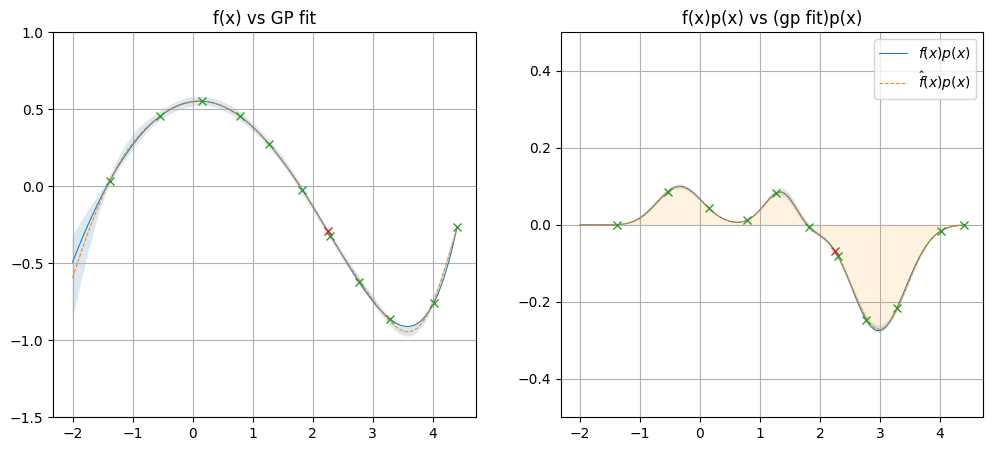

In [10]:
def f(x):
    # Target function to integrate
    return 0.5*(0.1*jnp.exp(x) - 0.5*x**2 + 1)

def fp_mix(x, params, weights=None):
    # Computes f(x) multiplied by mixture PDF for importance weighting
    mu_params = jnp.array(params[0])
    s_params = jnp.array(params[1])
    n_components = len(mu_params)

    # Normalize weights if not provided
    if weights is None:
        weights = jnp.ones(n_components)/n_components
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    px_sum = 0.0
    # Sum contributions of all mixture components
    for i in range(n_components):
        px = (1/(s_params[i]*jnp.sqrt(2*jnp.pi))) * \
                jnp.exp(-(x - mu_params[i])**2/(2*s_params[i]**2))
        px_sum += weights[i]*f(x)*px

    return px_sum

def FP(params, weights=None):
    # Analytical expectation of f(x) under the mixture
    mu_params = jnp.array(params[0])
    s_params = jnp.array(params[1])
    n_components = len(mu_params)

    # Normalize weights if not provided
    if weights is None:
        weights = jnp.ones(n_components)/n_components
    else:
        weights = jnp.array(weights)/jnp.sum(weights)

    integral = 0.0
    # Sum over mixture components
    for i in range(n_components):
        t1 = 0.1*jnp.exp(s_params[i]**2/2 + mu_params[i])
        integral += weights[i]*0.5*(t1 - 0.5*s_params[i]**2 - 0.5*mu_params[i]**2 + 1)

    return integral

# Define mixture parameters
mu = jnp.array([-0.4, 1.5, 2.8])
sigma = jnp.array([0.4, 0.3, 0.5])
weights = jnp.array([0.2, 0.3, 0.5])
params = (mu, sigma)
# Compute true integral value
true_value = FP(params, weights)

# Integration bounds based on mixture
lower = float(min(mu) - 4*jnp.mean(sigma))
upper = float(max(mu) + 4*jnp.mean(sigma))

# Points to evaluate GP / plots
x_eval = np.linspace(lower, upper, 150)

# GP hyperparameters
s = 0.3
L = jnp.array([0.9])
s, L, m0, x_m, w = jnp.array([s]), jnp.diag(L), jnp.array([0]), jnp.array([1]), 2
hp_sample = (s, L, m0, x_m, w, 0.0)

# Number of adaptive points
n_total = 12
x_data = jnp.array([])
y_data = jnp.array([])

# 1) first point uniformly sampled
x1 = jnp.array(np.random.uniform(lower, upper,1))
x_data = jnp.append(x_data, x1)
y_data = jnp.append(y_data, f(x1))

# Initial inverse kernel for GP
_, kxx_inv = kinv(jnp.atleast_1d(x1), hp_sample)

# Compute mixture PDF for plotting
y1 = mixture_pdf_1(x_eval, params[0], params[1], weights=weights)
plt.plot(x_eval, y1, label=r'$p(x) \sim \mathcal{N}_{mix}(\mu, \sigma^2)$', color='red')
plt.legend()
plt.grid()
plt.title("Mixture pdf")
plt.show()

print(f"Eₚ[f(x)]: {true_value}")
print("\nBayesian Quadrature (Adaptive Selection)\n")

for n in range(1, n_total + 1):
    # Reshape data for GP functions
    x, y = reshape(x_data, y_data)

    # Compute GP-integrated estimate and variance
    I_mu, I_var = integrate_mixture_1(x, y, s, L, params, weights, m0, x_m, w)
    error = jnp.abs(true_value - I_mu)

    print(f"{n} pts:")
    print(f"Estimate: {I_mu:.8f} , StDev: {jnp.sqrt(I_var):.8f}")
    print(f"Absolute Error: {error:.8f}\n")

    # GP prediction on grid
    mu_eval, sig_mat = gp_predict(
        x, y, x_eval,
        s=s, L=jnp.diag(L),
        m0=m0, x_m=x_m, w=w,
        K_inv=kxx_inv
    )

    # Extract diagonal standard deviation
    sig_diag = jnp.clip(jnp.diag(sig_mat[0]), a_min=1e-12)

    # Prepare arrays for plotting
    y2 = f(x_eval)                 # True function
    y3 = mu_eval                   # GP fit
    y4 = fp_mix(x_eval, params, weights) # f(x)p(x)
    y5 = y1 * y3                   # GP times mixture

    # Mask for integration bounds
    mask = (x_eval >= lower) & (x_eval <= upper)
    points_fill = x_eval[mask]
    y5 = y1 * mu_eval
    y_fill = y5[mask]

    # Plot GP vs true function
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x_eval, y2, label=r'$f(x)$', ls='-', lw=0.75)
    plt.plot(x_eval, y3, label=r'$\hat{f}(x)$ - GP Fit', ls='--', lw=0.75)
    plt.plot(x[:-1], y[:-1], 'x')  # training points
    plt.plot(x[-1:], y[-1:], 'x')
    plt.fill_between(x_eval, mu_eval - 2*jnp.sqrt(sig_diag), mu_eval + 2*jnp.sqrt(sig_diag), alpha=0.17)  # uncertainty shading
    #plt.legend()
    plt.grid()
    plt.ylim(-1.5, 1)
    plt.title("f(x) vs GP fit")

    # Plot f(x)p(x) vs GP*p(x)
    plt.subplot(1, 2, 2)
    plt.plot(x_eval, y4, label=r'${f}(x)p(x)$', ls='-', lw=0.75)
    plt.plot(x_eval, y5, label=r'$\hat{f}(x)p(x)$', ls='--', lw=0.75)
    plt.fill_between(x_eval, y1*y3 - 2 * jnp.abs(y1)*jnp.sqrt(sig_diag),
                        y1*y3 + 2 * jnp.abs(y1)*jnp.sqrt(sig_diag), alpha=0.17)  # GP uncertainty shading                  
    plt.plot(x[:-1], (y[:-1].ravel() * mixture_pdf_1(x[:-1], params[0], params[1], weights)), 'x')
    plt.plot(x[-1:], (y[-1:].ravel() * mixture_pdf_1(x[-1:], params[0], params[1], weights)), 'x')
    plt.legend()
    plt.grid()
    plt.title("f(x)p(x) vs (gp fit)p(x)")
    plt.ylim(-0.5, 0.5)
    plt.fill_between(points_fill, y_fill, color='orange', alpha=0.125)  # integral shading

    plt.show()

    # Select next point adaptively (maximize acquisition)
    if n < n_total:
        mu_params = jnp.array(params[0])
        s_params  = jnp.array(params[1])
        n_components = len(mu_params)

        x_eval = x_eval.ravel()

        # Compute kernel contributions for each mixture component
        kFs = jnp.stack([vk1(x_eval, s, L, mu_params[i], s_params[i]).reshape(-1, 1)
                        for i in range(n_components)], axis=0)
        kF = jnp.sum(weights[:, None, None]*kFs, axis=0).ravel()

        # Acquisition function (variance weighted)
        acq = kF**2*sig_diag

        # Choose next evaluation point
        next_idx = int(jnp.argmax(acq.ravel()))
        x_next = jnp.array(x_eval[next_idx])
        y_next = f(x_next)

        # Append new point to dataset
        x_data = jnp.append(x_data, x_next)
        y_data = jnp.append(y_data, y_next)

        # Update inverse kernel efficiently
        kxx_inv = rank_one_update(x_data, kxx_inv, hp_sample)
